In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

In [2]:
import os 
from glob import glob
import random
import numpy as np

In [3]:
os.listdir("cropped_dataset/train")

['1', '2', '.ipynb_checkpoints', '0']

In [4]:
train_dir = "cropped_dataset/train" 
test_dir = "cropped_dataset/test"

# fit 데이터셋 만들기

In [5]:
train_path = glob(train_dir+"/*/*.jpg")
test_path = glob(test_dir+"/*/*.jpg")

In [6]:

random.seed(0)
random.shuffle(train_path)
random.shuffle(test_path)
print(train_path[0])
print(test_path[0])

cropped_dataset/train/1/aug_3_0_4612.jpg
cropped_dataset/test/0/aug_1_2_0_3803.jpg


In [7]:
def get_label(filepath):
    return filepath.split("/")[-2]

In [8]:
train_x = []
for file in train_path:
    gfile = tf.io.read_file(file)
    image = tf.io.decode_image(gfile)
    image = tf.image.resize(image, [50, 50])
    image = tf.image.rgb_to_grayscale(image)
    train_x.append(np.asarray(image))

In [9]:
train_y = [get_label(file) for file in train_path]

In [10]:
test_x = []
for file in test_path:
    gfile = tf.io.read_file(file)
    image = tf.io.decode_image(gfile)
    image = tf.image.resize(image, [50, 50])
    image = tf.image.rgb_to_grayscale(image)
    test_x.append(np.asarray(image))

In [11]:
test_y = [get_label(file) for file in test_path]

In [12]:
train_x[10].shape

(50, 50, 1)

In [13]:
type(train_x[0].shape)
print(type(np.array(train_x[0])))

<class 'numpy.ndarray'>


In [14]:
len(train_y)

13395

In [15]:
np.unique(train_y, return_counts=True)

(array(['0', '1', '2'], dtype='<U1'), array([4478, 4419, 4498]))

In [16]:
np.unique(test_y, return_counts=True)

(array(['0', '1', '2'], dtype='<U1'), array([496, 489, 498]))

In [17]:
train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
test_x = np.asarray(test_x)
test_y = np.asarray(test_y)

In [18]:
train_x = train_x/255
test_x = test_x/255

In [19]:
train_y = to_categorical(train_y, 3)
test_y = to_categorical(test_y, 3)

# Feature Extraction (PCA)

In [20]:
from sklearn.decomposition import PCA
import pandas as pd

In [21]:
def extract_features(file):
    pca = PCA(n_components=1)
    x = file.squeeze()
    comp = pca.fit_transform(x)
    return comp

In [22]:
train_x_feature = [ extract_features(item) for item in train_x]

In [23]:
test_x_feature = [extract_features(item) for item in test_x]

In [24]:
train_x_feature = np.asarray(train_x_feature)

In [25]:
test_x_feature = np.asarray(test_x_feature)

# build model

### hyperparams

In [26]:
input_shape = (50,1)
batch_size = 5
learning_rate = 0.01
dropout_rate = 0.4
num_classes=3
num_epochs=30

In [27]:
#MODEL_SAVE_FOLDER_PATH = "./model/"
#if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
#    os.mkdir(MODEL_SAVE_FOLDER_PATH)
#MODEL_PATH = MODEL_SAVE_FOLDER_PATH + "fd-" + "{epoch:02d}.hdf5"

In [28]:
#checkpoint = ModelCheckpoint(
#    filepath=MODEL_PATH,
#    monitor="val_loss",
#    verbose=1,
#    save_best_only=True
#)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10
)

### model structure

In [29]:
inputs = layers.Input(input_shape)
net = layers.Flatten()(inputs)

# 1 hidden layer
net = layers.Dense(128)(net)
net = layers.Activation("relu")(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
# 2 hidden layer
net = layers.Dense(128)(net)
net = layers.Activation("relu")(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)

#주의: binary classification에서는 output dense가 1이다 
net = layers.Activation("softmax")(net)
#net = layers.Activation("sigmoid")(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name="NN")

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [31]:
train_y = train_y.astype("int32")
test_y = test_y.astype("int32")

In [32]:
test_y[12]

array([0, 0, 1], dtype=int32)

In [33]:
hist = model.fit(
    train_x_feature, train_y,
    validation_data=(test_x_feature, test_y),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Train on 13395 samples, validate on 1483 samples
Epoch 1/30
13395/13395 [==============================] - 5s 378us/sample - loss: 1.0887 - accuracy: 0.3912 - val_loss: 1.0918 - val_accuracy: 0.3446
Epoch 2/30
13395/13395 [==============================] - 3s 258us/sample - loss: 1.1213 - accuracy: 0.3398 - val_loss: 1.0996 - val_accuracy: 0.3297
Epoch 3/30
13395/13395 [==============================] - 4s 287us/sample - loss: 1.1005 - accuracy: 0.3318 - val_loss: 1.0999 - val_accuracy: 0.3358
Epoch 4/30
13395/13395 [==============================] - 4s 305us/sample - loss: 1.1001 - accuracy: 0.3320 - val_loss: 1.0988 - val_accuracy: 0.3345
Epoch 5/30
13395/13395 [==============================] - 4s 328us/sample - loss: 1.0999 - accuracy: 0.3356 - val_loss: 1.0986 - val_accuracy: 0.3345
Epoch 6/30
13395/13395 [==============================] - 5s 357us/sample - loss: 1.1003 - accuracy: 0.3290 - val_loss: 1.1038 - val_accuracy: 0.3297
Epoch 7/30
13395/13395 [===========================

In [34]:
model.summary()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               512      

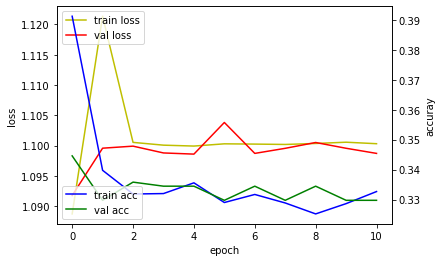

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()